# Introduction 

Vapnik’s Razor tells us that "when solving a (learning) problem of interest, do not solve a more complex problem as an intermediate step." Suppose we want to find the value that will minimize some cost function (a rather standard problem in statistics). From what we learned in class, we could use a procedure like simulated annealing to do this. However, simulated annealing takes a long time, and requires progressively more and more time to accurately sample the markov chain when tau gets small. It is also giving us a sampling of the chain, something that we might need to do, but don't really need if we are just after the minimum of some cost value. This becomes more of a problem when our chain becomes large (lets say uncountably infinite), as it will take longer to sample the chain. 

Instead, we will use a method called Particle Swarm Optimization. This idea, originally developed by Kennedy and Eberhart in 1995, mimics the behavior of insect swarms like ants and bees. These insects, despite having almost no intersting cognition occuring at an individual level, collectively are able to solve compelx problems. The basic idea of this algorthm will be to generate a series of particles (representative of insects), that are capable of tracking their previous best state and the swarm's best state. The swarm will then move around our space, and hopefully converge to an optimal solution. 


# Cost Function

Let's design a function to test this method on. To make it interesting, let's choose a function that doesn't have a well defined gradient, otherwise we could use gradient descent or nesterov acceleration, which we know we can't beat asymptotically. Let's also add some discontinuities, a few major local minima that are both very deep (which gives simulated annealing trouble) and very wide (which gives simualted annealing is somewhat robust to, but gives trouble to some other metroplis hasting type algorthms). Beyond these larger local minima, we also will add alot of small local minima.

We want our space of interest to be within -100 and 100 (the swarm might explore outside this area, but the local minimia and the global minima will be within this range), outside this range the function will continue to increase. Beyond the simple discontinuities and local minima we built in, the function is also comprised of trig functions, so there are local minima everywhere. The function and its plot are shown below.  

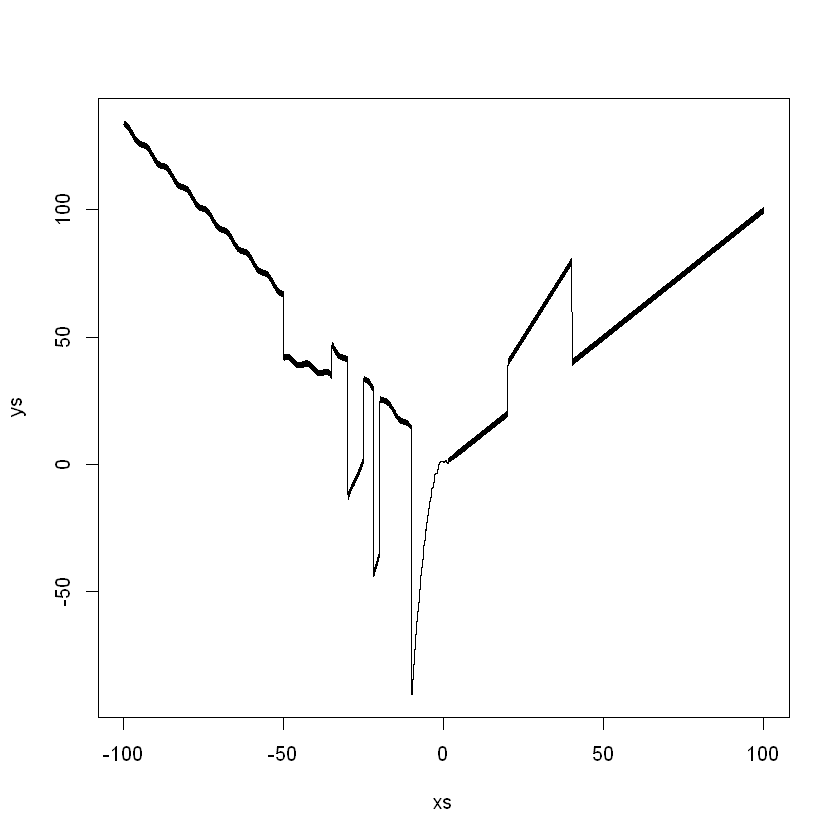

In [2]:
cost <- function(x) return(((x<(-10))*(sin(x)+abs(x/3)))+((x^2)*tanh(x)*(x<0)*(x>=(-10))) + 
                           ((.15*x^2)*tanh(x)*(x<(-20)))*(x>=(-22)) + ((.01*x^2)*tanh(x)*(x<(-35)))*(x>=(-50)) + 
                           ((-.002*x^3)*tanh(x)*(x<(-25)))*(x>=(-30)) + (x*(x<=40)*(x>=20)) + sin(x^2+exp(x))+abs(x))

xs <- seq(-100,100,0.001)
ys <- cost(xs)
plot(xs,ys, type='l')

# Swarm Behavior

Now we need to code the behavior of the swarm. Each particle's motion at a given point in time is determined by 3 things, it's previous motion, the distance from the particle's previous best, and the particles distance from the swarm's best. There are a few parameters that we need to tune. First, we need to choose the number of particles in our swarm. Next we need to choose the inertia of each particle (how much the previous motion of the particle affects the current motion of the particle). Then we have two scaling parameters that control the particle's memory (how much it cares about its previous best), and the swarm's communication (how much each particle cares about the swarm best). Each of these parameters are multiplied by a random uniform between zero and one, which introduces noise so that each particle's behavior is not deterministic. This is a stochastic search algorthm and we need to combine the competeting demands to explore the space, and converging the the current best solution. 

We initialize the particles randomly, with random velocities (between -1 and 1). We then update each particle's velocity, position, personal best, and global best. We store these variables for the swarm in a k by 4 matrix, and update the entire matrix to simulate the passing of a time step (in other words we are operating in discrete time and the new swarm optimum doesn't affect the behavior of the particles until every particle has had a chance to move and report the cost value at its location). 

In [3]:
### initializes a swarm of k particles in a range (a,b) with velocities uniformly distributed
### neg is a binary variable to determine if you want your range to be positive (0) or negative (1)
swarm.initialize <- function(k,a,b,neg = 0){
  num.particles <- k

  swarm <- matrix(ncol = 4, nrow = k)
  ifelse(neg == 1, swarm[,1] <- -runif(k,a,b), swarm[,1] <- runif(k,a,b))
  swarm[,2] <- runif(k,-1,1)
  swarm[,3] <- swarm[,1]
  swarm[,4] <- rep(swarm[which.min(cost(swarm[,1])),1],k)

  return(swarm)}


### function for updating the a given particle 

update <- function(x,v,x.best,g.best,w,c1,c2){
  
# new velocity is given by w (the inertia) times the old velocity 
# plus a term that measures how far the current position is from the particles best
# (mutliplied by a random uniform and a parameter c1 which is the particle's memory)
# plus a term that measures how far from the swarm's overall best, mutliplied by a 
# parameter that tells us how communicative the swarm is

# new position is old position plus velocity 
  
  v.new <- w*v + c1*runif(1,0,1)*(x.best-x) + c2*runif(1,0,1)*(g.best-x)
  x.new <- x + v.new
  ifelse(cost(x.best) > cost(x.new), x.best <- x.new, x.best <- x.best)
  ifelse(cost(g.best) > cost(x.new), g.best <- x.new, g.best <- g.best)

  return(c(x.new,v.new,x.best,g.best))}


### function for updating the swarm 
swarm.update <- function(swarm,w,c1,c2){
  k <- nrow(swarm)
  swarm.new <- matrix(ncol = 4, nrow = k)
  for(j in 1:k) {
    swarm.new[j,1:4] <- update(swarm[j,1],swarm[j,2],swarm[j,3],swarm[j,4],w,c1,c2)}
  
  swarm.new[,4] <- rep(swarm.new[which.min(cost(swarm.new[,4])),4],k)
  return(swarm.new)}


Now we put this together and simulate the particle's motion. I chose to simulate 4 particles (I could've chosen more or less, the more particles, the better you search the space, the only real downside is the added computational costs ). Each particle was initialized in a region of the space far away from the global minimum. The simulation was run for 100 time steps. We could use more precise stopping conditions such as when the distance from the global minimum get's within a certain amount, but that would require knowledge of the global minimum. Alternatively, we could define convergence as when all the particles settle into a region, but that will take a while, since the amount they care about the global and personal bests is random at each time step. We are best just setting a high number for n and letting it run. In this case 100 was chosen to demonstrate that the algrothm is capable of converging in a very short amount of time. 

The inertia (w) was set to 1 (typical values in the literature range from .8 to 1.2), the particle memory (c1) and communication (c2) were both set to 2 (which also tends to be a typical value in the literature). The plots of the cost function of the swarm's best position over time, the swarm's best over time plotted on the cost function, and some select points color coded to show convergence are all shown below. 

# Simulation Results

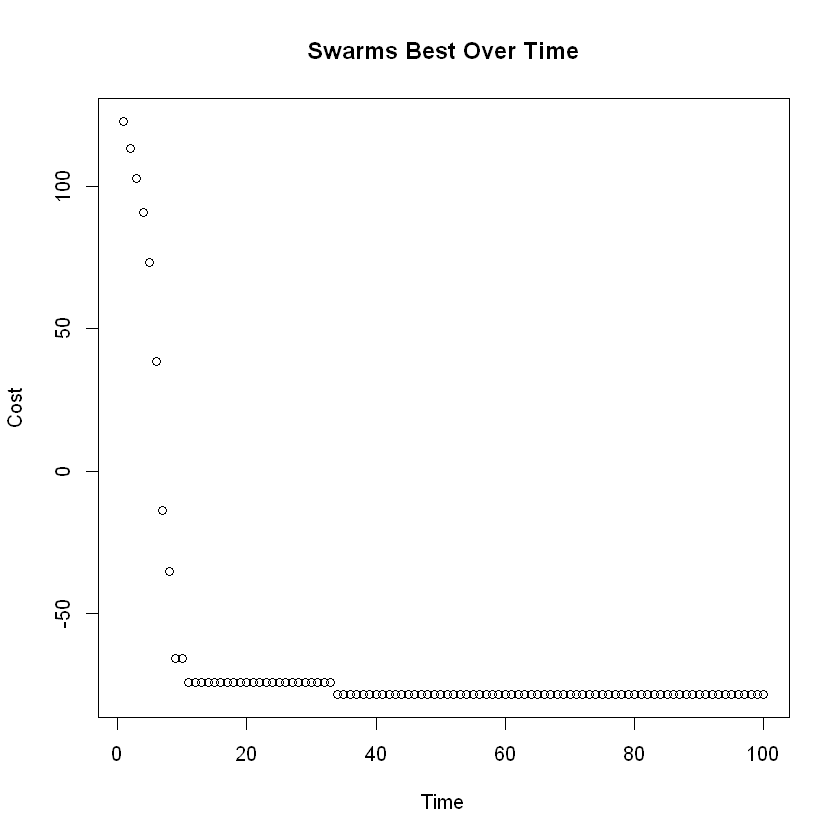

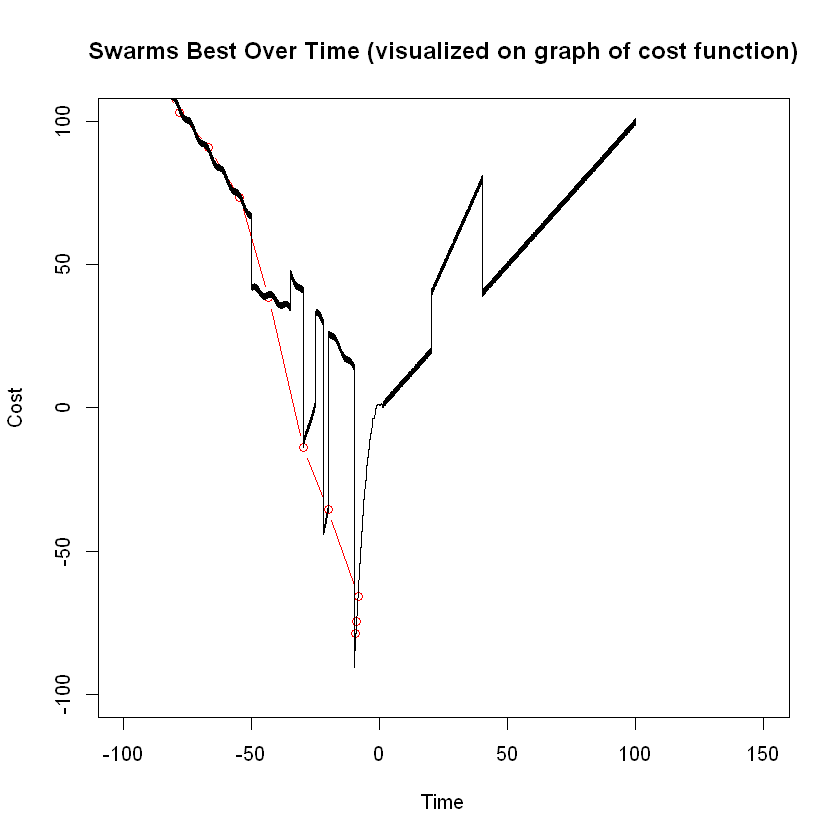

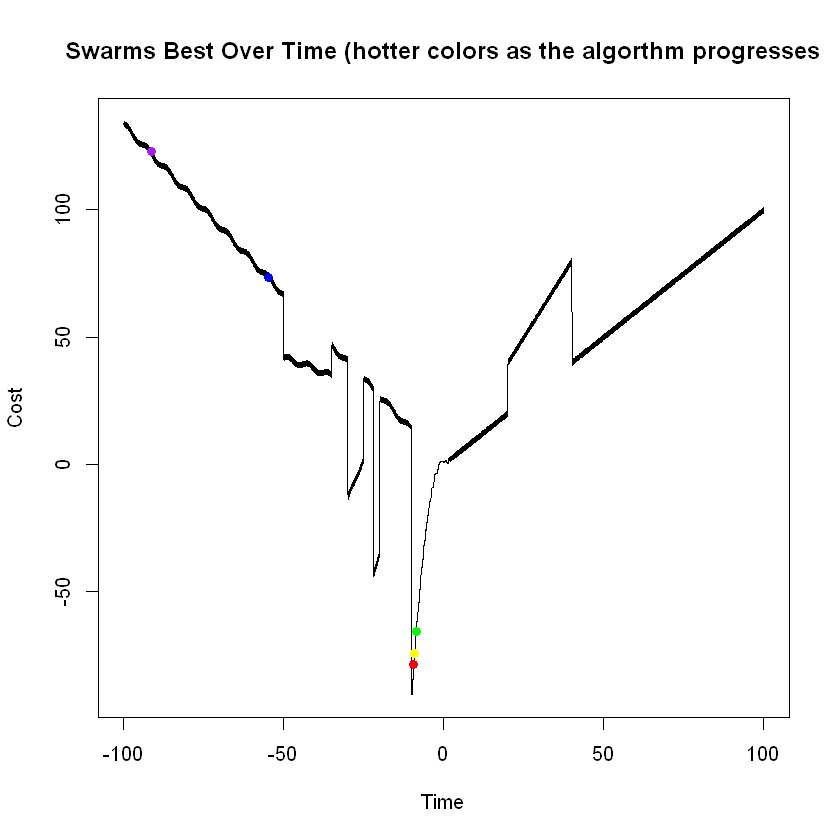

In [6]:
options(warn=-1)
# runs algorthm 
swarm.best <- c()
swarm <- swarm.initialize(4,90,100,1)
for(i in 1:100){
  swarm <- swarm.update(swarm,1,2,2)
  swarm.best <- c(swarm.best,swarm[1,4])
}

### plots results
plot(cost(swarm.best), main = "Swarms Best Over Time", ylab = "Cost", xlab = "Time")
plot(swarm.best,cost(swarm.best), type = 'b', col = 'red',  xlim = c(-100,150), ylim = c(-100,100), main = "Swarms Best Over Time (visualized on graph of cost function)", ylab = "Cost", xlab = "Time")
lines(xs,ys)


xs <- seq(-100,100,0.01)
ys <- cost(xs)
plot(xs,ys, type = 'l', main = "Swarms Best Over Time (hotter colors as the algorthm progresses", ylab = "Cost", xlab = "Time")
points(swarm.best[1],cost(swarm.best[1]), col = 'purple',pch=16) 
points(swarm.best[5],cost(swarm.best[5]), col = 'blue',pch=16) 
points(swarm.best[10],cost(swarm.best[10]), col = 'green',pch=16) 
points(swarm.best[25],cost(swarm.best[25]), col = 'yellow',pch=16) 
points(swarm.best[50],cost(swarm.best[50]), col = 'orange',pch=16) 
points(swarm.best[100],cost(swarm.best[100]), col = 'red',pch=16) 

Not bad, the swarm was able to get fairly close to the global optimium of the cost function, while avoiding local minimia that are both very wide (difficult for some metropolis algorthms to deal with), and very deep (difficult for algorthms like simulated annealing to overcome). Furthermore, we save the time that those algrothm's necessitate in order to get a good exploration of the space. By tracking the global minimum, the particles get shifted towards that at each step, while still wandering the space, which allows them to find the minimum rather quickly. 

We were also able to do this in 100 time steps with 4 particles (so less than 400 samples taken), and looking at the plot of the cost function, we see that we essentially converged around 50 (so only 200 samples taken). That's great, even if we didn't get perfect convergence, we likely would do alot better with a few thousand runs, and that would also be very computationally cheap to do. This seems like a promising non-parametric algorthm to add to our tool kit for optimization problems. 

There are still a few things that should make us hesitant to use this algorthm. First, is that it appears to lack robust analytical results that prove that it can efficiently converge, although it has had a great deal of empirical success. Second, it has alot of parameters that it's performance is dependent on. Too high of a interia parameter, and our particle will fly off somewhere in our space regardless of the cost function dynamics at those points. Too high of a communication of memory variable and the particle will quickly converge to that point while not exploring the space well. It is not obvious that these values will be the same for any problem (actually we would probably want them to be different, at the very least, for higher dimensional spaces, where we want more empahsis on exploration over rapid convergence), and this leads us to the same traps that exist with tools like neural networks. We have too many parameters to tune. Perhaphs chaining this algrothm with another that could effectively learn those parameters, or using some sort of corss validation routine to optimize them might avoid this somewhat naive reliance on literature results (although they worked out fairly well in this case). 

# Materials Used 

Supplementry Notes on PSO: http://www.cs.armstrong.edu/saad/csci8100/pso_slides.pdf
Original Paper: (https://www.cs.tufts.edu/comp/150GA/homeworks/hw3/_reading6%201995%20particle%20swarming.pdf)